In [1]:
#un canale

In [2]:
from NewLibraryENG import *
from tqdm.notebook import tqdm
import sklearn.preprocessing as ps
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from random import randint
from fastdtw import fastdtw
import copy
import pymc as pm
name_data = '2018-11-27T10-29-42POP 2 BL .h5'
name_data2 = '2018-11-27T12-03-02POP 2 stimulation.h5'
name_data3='2018-11-27T10-56-39MiP5 KA stimulation.h5'
name_data4='2018-11-27T11-24-28MiP3 stimulation.h5'
name_data5='2018-11-27T10-40-53POP 3 BL .h5'
complete_string='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data
complete_string2='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data2
complete_string3='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data3
complete_string4='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data4
complete_string5='/Users/Gaia_1/Downloads/PoiProMEA-master/h5files/'+name_data5

In [3]:
#data = h5py.File(complete_string,'r')
#data = h5py.File(complete_string2,'r')
#data = h5py.File(complete_string3,'r')
data = h5py.File(complete_string4,'r') #Stimulated
#data = h5py.File(complete_string5,'r') #BL

data_readings = data['Data']['Recording_0']['AnalogStream']['Stream_0']['ChannelData'][()]
info = data['Data']['Recording_0']['AnalogStream']['Stream_0']['InfoChannel'][()]
info_table = pd.DataFrame(info, columns = list(info.dtype.fields.keys()))
labels = info_table['Label']
readings = pd.DataFrame(data = data_readings.transpose(), columns = labels)
fs = 10000 #Sampling Frequency
print(readings.shape)

(4212000, 60)


In [4]:
inizio=0
#len_data=810000 #192 secondi
len_data=len(readings)
prova_multi=readings.iloc[inizio:len_data, :17]
#prova=prova.drop([b'Ref'],axis=1)
prova=prova_multi[b'46']
ref=readings[b'Ref']
ref=ref[inizio:len_data]
#prova=readings.iloc[:150000, :5]
print(prova.shape,ref.shape)

(4212000,) (4212000,)


In [5]:
lowcut = 300
highcut = 3000
fs=10000
order=8
b,a=butter_bandpass(lowcut,highcut,fs,order=order)
filt_ref=filtfilt(b,a,ref)
filt_prova=filtfilt(b,a,prova)
f_prova = filt_prova - filt_ref
prova=f_prova
prova.shape
#r_prova=prova.reshape(-1, 1)
#scaler = StandardScaler()
#s_prova = scaler.fit_transform(r_prova)
#prova=s_prova
#s_prova.shape

(4212000,)

# Spike detection

In [6]:
pos, neg=find_all_spikes(prova)

  0%|          | 0/4202000 [00:00<?, ?it/s]

positive spikes 7481 negative spikes 12449 detected spikes: 19930 firing rate:  47.31718898385565


BL: window 3000 (threshold 4 MAD) firing 18    
BL: window 300 (thresh 3), firing 89    
KA: window 3000 (thresh 3), firing 94    
KA: window 3000 (thresh 4), firing 29    
KA: window 300, (thresh 4) firing 39   
KA: window 300, (thresh 3) firing 108   

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(pos, [prova[i] for i in pos], c='red', marker='o', label='Local Maxima')
plt.scatter(neg, [prova[i] for i in neg], c='green', marker='o', label='Local Minima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,3000,-5,5])
#plt.savefig('spikes1.jpg')
plt.show()

minima,maxima=RMM(prova)
print(len(maxima))
#segnale BASELINE: firing rate=70 (spikes 26148)
#segnale Stimulation: firing rate=69 (spikes 32980)
#segnale KA stimulation: firing rate=81 (spikes 47860)

minima,maxima=find_spikes(prova)
len(maxima)
#segnale BASELINE: firing rate=27 (spikes 10276)
#segnale Stimulation: firing rate=27 (spikes 13198)
#segnale KA stimulation: firing rate=32 (spikes 19178)

minima,maxima=find_spikes_with_memory(prova)
len(maxima)
#segnale BASELINE: firing rate=25 (spikes 9270)
#segnale Stimulation: firing rate=22 (spikes 10579)
#segnale KA stimulation: firing rate=8 (spikes 5054)

plt.figure(figsize=(30, 15))
plt.plot(prova, label='Signal Data')
plt.scatter(minima, [prova[i] for i in minima], c='red', marker='o', label='Local Minima')
plt.scatter(maxima, [prova[i] for i in maxima], c='green', marker='x', label='Local maxima')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.title('Signal Data with Detected Spikes')
#plt.axis([0,30000,-5,5])
#plt.savefig('spikes2.jpg')
plt.show()

# Cutouts

In [7]:
pos_cut,n_pos, neg_cut,n_neg = cut(pos,neg,prova)
#savedp = copy.deepcopy(pos_cut)
#savedn = copy.deepcopy(neg_cut)

In [8]:
pos_cut=mask_cuts(pos_cut)
neg_cut= mask_cuts(neg_cut)

x=randint(1,min(len(pos_cut),len(neg_cut)))

plt.plot(savedp[x])
plt.plot(pos_cut[x])
plt.show()
#plt.plot(savedn[x])
#plt.plot(neg_cut[x])
#plt.show()

import pandas as pd
pca = PCA()
pca.fit(pos_cut)
explained_variances = pca.explained_variance_ratio_
explained_variance_df = pd.DataFrame(data={'Explained Variance': explained_variances},
                                     index=range(1, len(explained_variances) + 1))
explained_variance_df.transpose()

cumulative_explained_variance = np.cumsum(explained_variances)
cumulative_explained_variance_df = pd.DataFrame(data={'Cumulative Explained Variance': cumulative_explained_variance},
                                                index=range(1, len(cumulative_explained_variance) + 1))
cumulative_explained_variance_df.transpose()


# Clustering

Total spikes:  7481
For 3 clusters, the silhouette score is: 0.216
For 4 clusters, the silhouette score is: 0.214
For 5 clusters, the silhouette score is: 0.216
For 6 clusters, the silhouette score is: 0.204
For 7 clusters, the silhouette score is: 0.181
For 8 clusters, the silhouette score is: 0.182
For 9 clusters, the silhouette score is: 0.172
For 10 clusters, the silhouette score is: 0.177


Best cluster in the range 3 to  10 :  5 , with a silhouette score of:  0.21626657413220501   


firing rate threshold:  2.1485701343981285


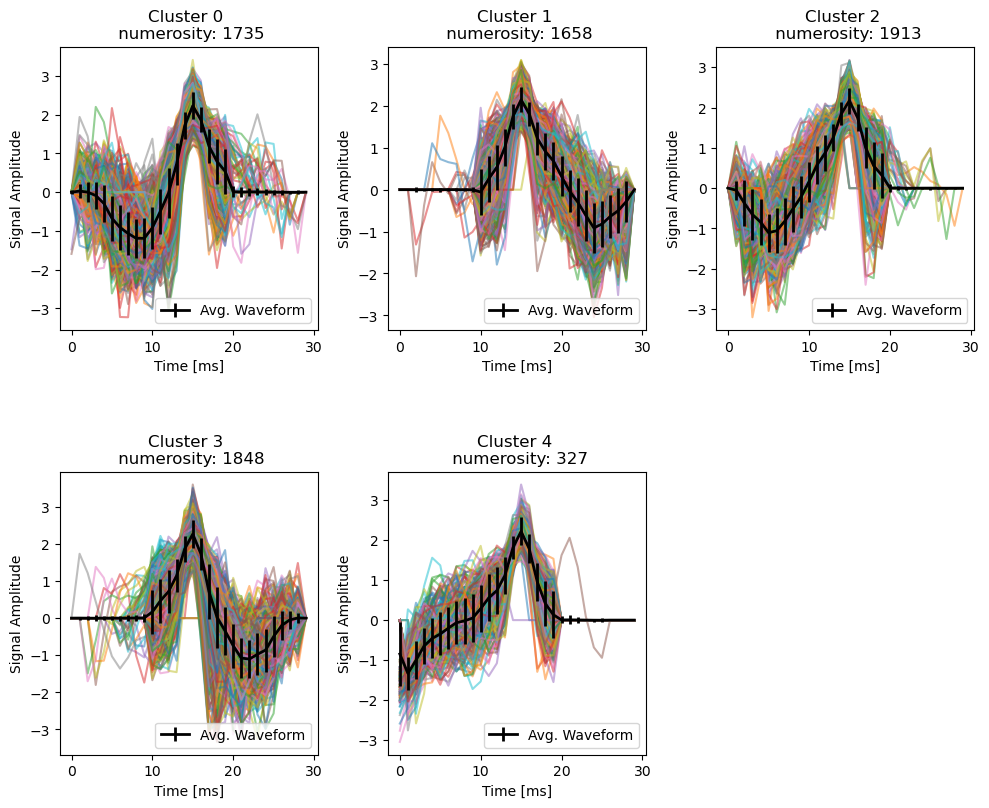

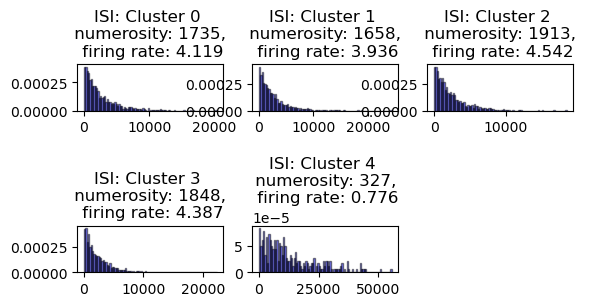

In [9]:
final_data_pos= clus(pos_cut,'kmeans',n_pos,prova)

BL (window 3000, thresh 4) (less function) fuzzy (1.8, 4, 3.99)   
BL (window 300) (less function) fuzzy (19, 18, 9)   
BL (window 300) (less function) dbscan (30, 9)   
BL (window 300) (bit less function std) fuzzy (8.9, 18.2, 17.8)   
BL (window 300) (more cut function) fuzzy (8.9, 17.7, 18.3)   
BL (window 300) (more cut function) dbscan (29, 6)   
BL (less cut function) fuzzy: (15, 8 ,15)   

KA (window 300, thresh 4) (less function) fuzzy (3.8, 4, 1.9)   
KA (window 3000, thresh 4) (less function) fuzzy (2.6, 1.2, 2.8)   
KA stimualtion 3 clusters fuzzy: (13, 6, 12)   
KA stim (window 300) (new cut function) (1.17,2.55,2.37)   


Total spikes:  12449
For 3 clusters, the silhouette score is: 0.224
For 4 clusters, the silhouette score is: 0.206
For 5 clusters, the silhouette score is: 0.215
For 6 clusters, the silhouette score is: 0.195
For 7 clusters, the silhouette score is: 0.189
For 8 clusters, the silhouette score is: 0.175
For 9 clusters, the silhouette score is: 0.164
For 10 clusters, the silhouette score is: 0.161


Best cluster in the range 3 to  10 :  3 , with a silhouette score of:  0.22384210297014384   


firing rate threshold:  7.21997392664837


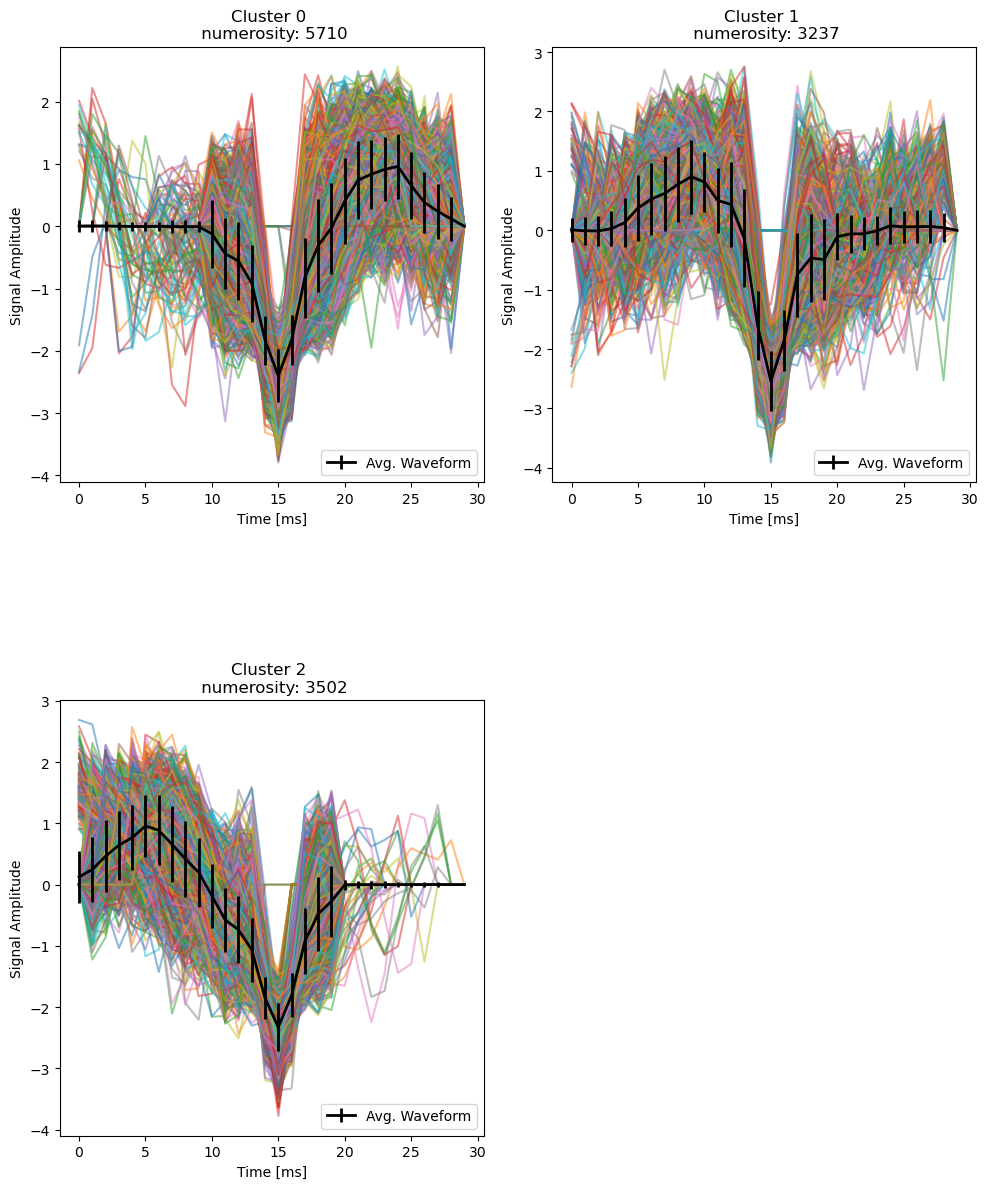

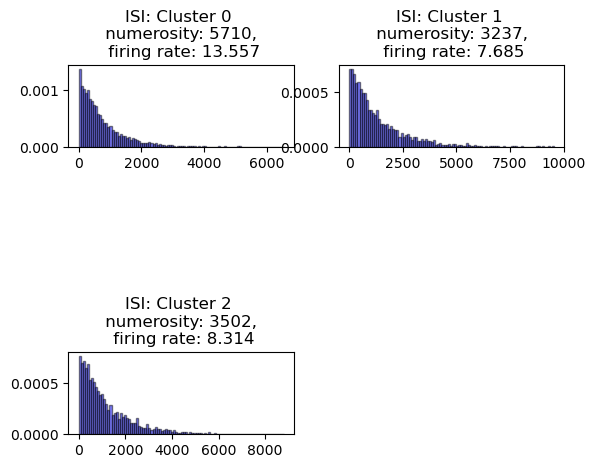

In [10]:
final_data_neg= clus(neg_cut,'kmeans',n_neg,prova)

BL (less cut function) (window 3000, thresh4) fuzzy: (3.5, 3.5, 1.6) silhouette: 0.231    
BL (less cut function) (window 300) fuzzy: (17, 15, 6) silhouette: 0.215    
BL (more cut function) (window 300) fuzzy: (15, 16, 7) silhouette: 0.218    
BL (less cut function) fuzzy: (13, 13, 6) silhouette: 0.226    

KA (less cut function) (window 300, thresh4) fuzzy: (1.9, 1.12, 1.9) silhouette: 0.229   
KA (less cut function) (window 3000, thresh4) fuzzy: (1.4, 0.89, 1.4) silhouette: 0.223    
KA stimulation 3 clusters fuzzy: (3.9, 3.7, 2) silhouette: 0.214    
KA stimulation (more cut function) (window 3000) fuzzy: (2, 3.9, 3.7) silhouette: 0.214    
KA stimulation (more cut function) (window 300) fuzzy (4.5, 4.4, 2.2) silhouette: 0.204    
KA stimulation (more cut function) (window 300) dbscan (10.8,10.8)    

In [17]:
neurons = []
for neuron in final_data_pos:
    neurons.append(neuron)
for neuron in final_data_neg:
    neurons.append(neuron)
neurons

[array([   5022,   16809,   19337, ..., 4200790, 4203615, 4205801]),
 array([   3155,    5119,    5146, ..., 4202764, 4203866, 4204162]),
 array([   2788,    9201,    9231, ..., 4200048, 4203618, 4204878]),
 array([   1084,   10036,   11066, ..., 4200620, 4202457, 4206485]),
 array([   2603,    4746,    5593, ..., 4206310, 4206630, 4206657]),
 array([   1090,    2476,    2874, ..., 4201623, 4202567, 4204414]),
 array([    467,    1014,    3669, ..., 4203680, 4203879, 4203932])]

neur:  6


(array([449., 418., 372., 326., 273., 238., 197., 160., 123., 114., 115.,
        108.,  81.,  69.,  75.,  41.,  50.,  33.,  37.,  33.,  23.,  27.,
         20.,  19.,   7.,  15.,   8.,  10.,  10.,   9.,   3.,   8.,   3.,
          6.,   3.,   2.,   1.,   2.,   1.,   3.,   2.,   2.,   1.,   3.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.00000e-04, 1.77880e-02, 3.53760e-02, 5.29640e-02, 7.05520e-02,
        8.81400e-02, 1.05728e-01, 1.23316e-01, 1.40904e-01, 1.58492e-01,
        1.76080e-01, 1.93668e-01, 2.11256e-01, 2.28844e-01, 2.46432e-01,
        2.64020e-01, 2.81608e-01, 2.99196e-01, 3.16784e-01, 3.34372e-01,
        3.51960e-01, 3.69548e-01, 3.87136e-01, 4.04724e-01, 4.22312e-01,
        4.39900e-01, 4.57488e-01, 4.75076e-01, 4.92664e-01, 5.10252e-01,
        5.27840e-01, 5.45428e-01, 5.63016e-01, 5.80604e-01, 5.98192e-01,
        6.15780e-01, 6.33368e-01, 6.50956e-01, 6.68544e-01, 6.86132e-01,
        7.03720e-01, 7.21308e-01, 7.38896e-01, 7.56484e-01, 7.74072e-01,
 

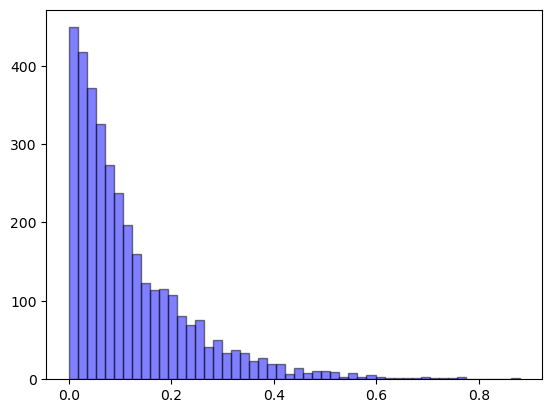

In [30]:
x=randint(0,len(neurons)-1)
print('neur: ',x)
data_healthy=neurons[x]
ISI_healthy = np.diff(data_healthy)/10000
plt.hist(ISI_healthy, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

In [26]:
data_healthy
ISI_healthy

array([ 547, 2655, 1543, ...,  864,  199,   53])

In [12]:
adj_neur=[]
counter = 0
max_len=0

for neu in neurons:
    print('counter: ',counter,neu.shape[0])
    if neu.shape[0]>max_len:
        max_len=neu.shape[0]
    counter+=1
for neuron in neurons:
    if neuron.shape[0]<=max_len:
        diff = max_len-neuron.shape[0]
        adj_neur.append(np.concatenate((neuron,np.zeros([diff]))))


counter:  0 1735
counter:  1 1658
counter:  2 1913
counter:  3 1848
counter:  4 5710
counter:  5 3237
counter:  6 3502


In [13]:
x=randint(0,len(adj_neur)-1)
print('neur: ',x)
data_healthy=adj_neur[x]
ISI_healthy = np.diff(data_healthy)/10000

neur:  3


(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 5.708e+03]),
 array([-4206485.  , -4121909.12, -4037333.24, -3952757.36, -3868181.48,
        -3783605.6 , -3699029.72, -3614453.84, -3529877.96, -3445302.08,
        -3360726.2 , -3276150.32, -3191574.44, -3106998.56, -3022422.68,
        -2937846.8 , -2853270.92, -2768695.04, -2684119.16, -2599543.28,
        -2514967.4 , -2430391.52, -2345815.64, -2261239.76, -2176663.88,
        -20

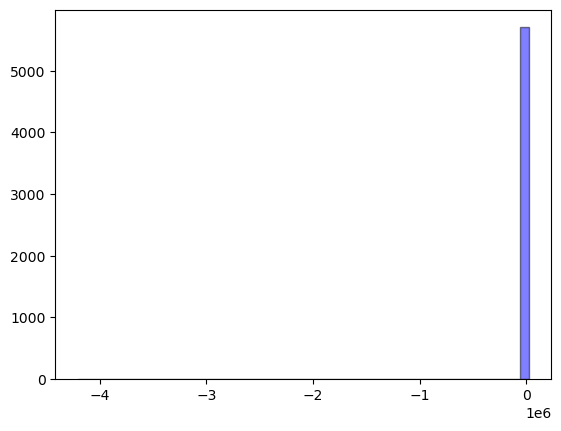

In [16]:
locs_diff=np.diff(data_healthy)
#plt.axis([-3,500,0,0.05])
plt.hist(locs_diff, bins=50, density=False, alpha=0.5, color='blue', edgecolor='black')

## Point Process

In [14]:
ISI_data=ISI_healthy

def Bayesian_mixture_model(ISI_data):
    with pm.Model() as model:
        ##### WALD DISTRIBUTION (INVERSE GAUSSIAN)
        mu1 = pm.Uniform('mu1',lower=0.01,upper=0.1)
        lam1 = pm.Uniform('lam1',lower=0.01,upper=0.04)
        obs1 = pm.Wald.dist(mu=mu1,lam=lam1)


        mu2 = pm.Uniform('mu2',lower=0,upper=0.2)
        sigma2 = pm.Uniform('sigma2',lower=0.0001,upper=0.5)
        obs2 = pm.TruncatedNormal.dist(mu=mu2, sigma=sigma2, lower=0.0)

        mu3 = pm.Uniform('mu3',lower=0.1,upper=0.6)
        sigma3 = pm.Uniform('sigma3',lower=0.0001,upper=0.5)
        obs3 = pm.TruncatedNormal.dist(mu=mu3, sigma=sigma3, lower=0.0)


        w = pm.Dirichlet('w', a=np.array([1., .4, .4]))
        #w = pm.Dirichlet('w', a=np.array([1., .4]))

        like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2, obs3], observed=ISI_data)
        #like = pm.Mixture('like', w=w, comp_dists = [obs1, obs2], observed=ISI_data)
        

        step = pm.NUTS(target_accept=0.9)
        trace = pm.sample(step=step,draws=1000,chains=1,tune=1000,cores=4)
        
    map_estimate = pm.find_MAP(model=model)
    del map_estimate['w_simplex__']
    del map_estimate['mu1_interval__']
    del map_estimate['lam1_interval__']
    del map_estimate['mu2_interval__']
    del map_estimate['sigma2_interval__']
    del map_estimate['mu3_interval__']
    del map_estimate['sigma3_interval__']

    map_estimate['w1'] = map_estimate['w'][0]
    map_estimate['w2'] = map_estimate['w'][1]
    map_estimate['w3'] = map_estimate['w'][2]

    del map_estimate['w']


    return map_estimate


In [15]:
map_estimate= Bayesian_mixture_model(ISI_healthy)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mu1_interval__': array(0.), 'lam1_interval__': array(0.), 'mu2_interval__': array(0.), 'sigma2_interval__': array(0.), 'mu3_interval__': array(-2.22044605e-16), 'sigma3_interval__': array(0.), 'w_simplex__': array([ 0.61086049, -0.30543024])}

Logp initial evaluation results:
{'mu1': -1.39, 'lam1': -1.39, 'mu2': -1.39, 'sigma2': -1.39, 'mu3': -1.39, 'sigma3': -1.39, 'w': -2.36, 'like': -inf}
You can call `model.debug()` for more details.

In [ ]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace,model=model)

bins = np.arange(0, .5, 1e-3) 
plt.figure (figsize=(14,10))

hist = np.histogram(ppc_trace['posterior_predictive']['like'].values,bins=bins)
#plt.axis([0,0.3,0,160])
a= plt.hist(ISI_healthy,bins)
plt.plot(hist[1][:-1],hist[0]/1000,linewidth=3);

In [ ]:
lista_samples=[]
for i in list(ppc_trace['posterior_predictive']['like'].values):
    lista_samples.extend(i)

In [ ]:
counts, _ = np.histogram(ISI_healthy, bins) 
prob_emp = counts / np.sum(counts)
counts, _ = np.histogram(lista_samples, bins) 
prob_model = counts / np.sum(counts)

Femp = np.cumsum(prob_emp)           
Fmodel = np.cumsum(prob_model)          
plt.figure()
plt.plot(bins[:-1], Femp)                
plt.plot(bins[:-1], Fmodel, 'r')       
#plt.xlim([0, 0.2])                  
plt.xlabel('Time [s]')
plt.ylabel('CDF')
plt.legend(['Empirical','Model'])
plt.show()

In [ ]:
plt.figure()
Nlow = len(ISI_healthy)  
# Plot the confidence bounds
plt.plot([0, 1], [x + 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot([0, 1], [x - 1.36 / np.sqrt(Nlow) for x in [0, 1]], 'r:')
plt.plot(Femp, Fmodel)
plt.axis([0, 1, 0, 1])         
plt.xlabel('Model CDF')
plt.ylabel('Empirical CDF')
plt.show()

In [ ]:
map_estimate = pm.find_MAP(model=model)
del map_estimate['w_simplex__']
del map_estimate['mu1_interval__']
del map_estimate['lam1_interval__']
del map_estimate['mu2_interval__']
del map_estimate['sigma2_interval__']
del map_estimate['mu3_interval__']
del map_estimate['sigma3_interval__']

map_estimate['w1'] = map_estimate['w'][0]
map_estimate['w2'] = map_estimate['w'][1]
map_estimate['w3'] = map_estimate['w'][2]

del map_estimate['w']


map_estimate

In [ ]:
dataframe = pd.DataFrame()
list_neurons = adj_neur
counter=0
print('Original number of neurons: ',len(list_neurons))
for neuron in list_neurons:
    neuron=neuron[neuron>0*10000]
    neuron=neuron[neuron<200*10000]
    print('  Neuron with ',neuron.shape[0],'spikes')
    if neuron.shape[0]>1000:

        counter+=1
    else:
        print('    Excluded neuron with n spikes = ',neuron.shape[0])
        continue

    ISI_healthy = np.diff(neuron)/10000


    map_estimate = Bayesian_mixture_model(ISI_healthy)

    df = pd.DataFrame.from_dict(map_estimate,orient='index')
    dataframe = pd.concat([dataframe,df],axis = 1)
print('Final number of neurons: ',counter)
print('Target = ',target)

In [ ]:
final = dataframe.T
final.to_csv('Data after PP/DataAfter')

## Classification

In [ ]:
def performance_visualizer(trials_obj,n_models,choice=False,**choice_var):
    
    import pandas as pd
    
    performance = [1-t['result']['loss'] for t in trials_obj.trials]
    
    
    hyperparam= list(trials_obj.trials[0]['misc']['vals'].keys())
    
    values_dict ={}
    
    for i in hyperparam:
        
        values_dict[i]=[]
        
        for j in trials_obj.trials:
            
            if(len(j['misc']['vals'][i])==0):
                
                values_dict[i].append(np.NaN)
                
            else:
            
                values_dict[i].append(j['misc']['vals'][i][0])
                
    out = pd.DataFrame.from_dict(values_dict)
    
    out['performance'] = performance
    
    out=out.sort_values(by=['performance'])
    
    
    if choice:
        
        for i in list(choice_var.keys()):
        
            for j,_ in enumerate(choice_var[i]):
        
                out[i]=out[i].replace(j,choice_var[i][j])
    
    return out.tail(n_models)

In [ ]:
dataset = pd.read_csv('Data after PP/Data')
dataset = dataset.drop(['Unnamed: 0'],axis=1)
dataset